<a href="https://colab.research.google.com/github/young-hwanlee/gnn_examples/blob/main/2_gnn_graph_level_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/young-hwanlee/gnn_examples.git

Cloning into 'gnn_examples'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 75 (delta 40), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 1.65 MiB | 8.74 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
# ## To avoid some errors (출처: https://life-is-potatoo.tistory.com/95 [삶은 감자:티스토리]) ==========
# ## 1st method
# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# def format_pytorch_version(version):
#     return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)
# def format_cuda_version(version):
#     return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

## Ensure that the PyTorch and the PyG are the same version
# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric

## 2nd method
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install torch_geometric

## Ensure that the PyTorch and the PyG are the same version
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pytorch_metric_learning

## Both methods are too slow.

2.4.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 3.0 MB/s eta 0:00:00


In [3]:
## Import required packages ====================================================================
# import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GATConv
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.loader import DataLoader

import numpy as np
import random
from sklearn.model_selection import train_test_split

In [4]:
## Set up the seed for reproducibility ============================================================
seed = 42

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)     # if use multi-GPU

np.random.seed(seed)

random.seed(seed)

In [5]:
## Load a dataset ===============================================================================
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root="/tmp/PROTEINS", name="PROTEINS", transform=torch_geometric.transforms.ToDevice(device))

Processing...
Done!


In [6]:
print(f'Dataset: {dataset}:')
print('============================================================================================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of labels: {len(dataset.y)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Classes: {torch.unique(dataset.y)}')
print(f'Number of y = 0: {len(np.array(torch.where(dataset.y == 0)).flatten())}')
print(f'Number of y = 1: {len(np.array(torch.where(dataset.y == 1)).flatten())}')
print('============================================================================================')
for i in range(0, len(dataset)):
    if i % 100 == 0:
        print(f'{i} : {dataset[i]}')

Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of labels: 1113
Number of features: 3
Number of classes: 2
Classes: tensor([0, 1])
Number of y = 0: 663
Number of y = 1: 450
0 : Data(edge_index=[2, 162], x=[42, 3], y=[1])
100 : Data(edge_index=[2, 214], x=[50, 3], y=[1])
200 : Data(edge_index=[2, 216], x=[52, 3], y=[1])
300 : Data(edge_index=[2, 332], x=[96, 3], y=[1])
400 : Data(edge_index=[2, 114], x=[33, 3], y=[1])
500 : Data(edge_index=[2, 150], x=[43, 3], y=[1])
600 : Data(edge_index=[2, 180], x=[46, 3], y=[1])
700 : Data(edge_index=[2, 12], x=[4, 3], y=[1])
800 : Data(edge_index=[2, 188], x=[45, 3], y=[1])
900 : Data(edge_index=[2, 46], x=[11, 3], y=[1])
1000 : Data(edge_index=[2, 18], x=[5, 3], y=[1])
1100 : Data(edge_index=[2, 128], x=[36, 3], y=[1])


In [7]:
len(dataset)

1113

In [8]:
dataset[700].x

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [21]:
for i in range(0, len(dataset)):
    if i % 100 == 0:
        print(dataset[i].y)

tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])


AttributeError: 'Graph' object has no attribute 'mean'

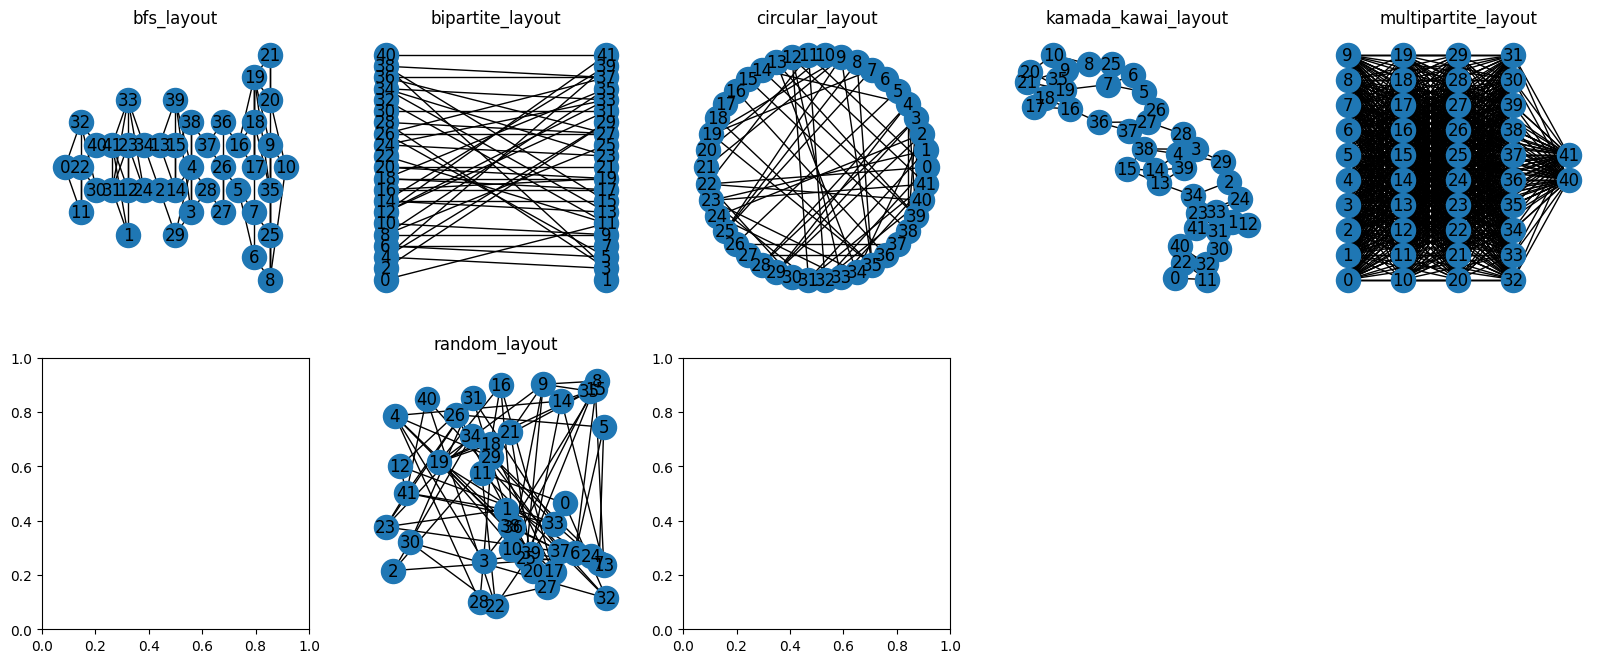

In [146]:
## Visualize the GNN networks ===================================================================
## Import packages required for visualization
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE

import string

%matplotlib inline

def plot_graph(G, pos, pos_name, color=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{pos_name}')

    plt.sca(ax)

    fig.set_tight_layout(False)     # Layout is not set
    nx.draw(G, pos, with_labels=True, node_color=color, cmap="Set2")





# nx.bfs_layout (G, start, *[, align, scale, center]) : Position nodes according to breadth-first search algorithm.
# nx.bipartite_layout (G, nodes[, align, scale, ...]) : Position nodes in two straight lines.
# nx.circular_layout (G[, scale, center, dim]) : Position nodes on a circle.
# nx.kamada_kawai_layout (G[, dist, pos, weight, ...]) : Position nodes using Kamada-Kawai path-length cost-function.
# nx.multipartite_layout (G[, subset_key, align, ...]) : Position nodes in layers of straight lines.
# nx.planar_layout (G[, scale, center, dim]) : Position nodes without edge intersections.
# nx.random_layout (G[, center, dim, seed]) : Position nodes uniformly at random in the unit square.
# nx.rescale_layout (pos[, scale]) : Returns scaled position array to (-scale, scale) in all axes.
# nx.rescale_layout_dict (pos[, scale]) : Return a dictionary of scaled positions keyed by node
# nx.shell_layout (G[, nlist, rotate, scale, ...]) : Position nodes in concentric circles.
# nx.spectral_layout (G[, weight, scale, center, dim]) : Position nodes using the eigenvectors of the graph Laplacian.
# nx.spiral_layout (G[, scale, center, dim, ...]) : Position nodes in a spiral layout.
# nx.spring_layout (G[, k, pos, fixed, ...]) : Position nodes using Fruchterman-Reingold force-directed algorithm.
# nx.arf_layout (G[, pos, scaling, ...]) : attractive and repulsive forces (arf) layout; improved spring layout.

n_nodes = dataset[0].x.shape[0]
nodes_list = list(range(n_nodes))

fig = plt.figure(figsize=(20, 12))

for i in range(14):
    ax_name = 'ax' + str(i + 1)
    # print(ax_name)
    ax_name = fig.add_subplot(3, 5, i + 1)
    G = to_networkx(data=dataset[0], to_undirected=True)
    pos = None

    ## ===============================================
    if i == 0:
        pos = nx.bfs_layout(G, start=0)
        pos_name = 'bfs_layout'
    elif i == 1:
        nodes = []
        for node in range(n_nodes):
            if node % 2 == 0:
                nodes = nodes + [node]
        pos = nx.bipartite_layout(G, nodes=nodes)
        pos_name = 'bipartite_layout'
    elif i == 2:
        pos = nx.circular_layout(G)
        pos_name = 'circular_layout'
    elif i == 3:
        pos = nx.kamada_kawai_layout(G)
        pos_name = 'kamada_kawai_layout'
    elif i == 4:
        ## 1st method : nx.complete_multipartite_graph(subset_sizes)
        # n = 10
        # layers = [nodes_list[k * n:(k + 1) * n] for k in range((len(nodes_list) + n - 1) // n )]
        G = nx.complete_multipartite_graph(10, 10, 10, 10, 2)       # but only integers, not list, tupple, ...
        pos = nx.multipartite_layout(G)

        # ## 2nd method : use a dict
        # pos = nx.multipartite_layout(G, subset_key=)
        pos_name = 'multipartite_layout'
    ## ===============================================
    elif i == 5:
        try:
            pos = nx.planar_layout(G)       # NetworkXException: G is not planar.
        except nx.exception.NetworkXException:
            pos_name = 'planar_layout'
            continue

    elif i == 6:
        pos = nx.random_layout(G)
        pos_name = 'random_layout'
    elif i == 7:
        pos = nx.rescale_layout(G)
        pos_name = 'rescale_layout'
    elif i == 8:
        pos = nx.rescale_layout_dict(G)
        pos_name = 'rescale_layout_dict'
    elif i == 9:
        pos = nx.shell_layout(G)
        pos_name = 'shell_layout'
    ## ===============================================
    elif i == 10:
        pos = nx.spectral_layout(G)
        pos_name = 'spectral_layout'
    elif i == 11:
        pos = nx.spiral_layout(G)
        pos_name = 'spiral_layout'
    elif i == 12:
        pos = nx.spring_layout(G)
        pos_name = 'spring_layout'
    elif i == 13:
        pos = nx.arf_layout(G)
        pos_name = 'arf_layout'
    ## ===============================================

    plot_graph(G, pos, pos_name, ax=ax_name)


# layers[0, :]
# keys = layers
# values = layers
# layers_dict = { k:v for (k, v) in zip(keys, values)}
# print(layers_dict)
# pos = nx.multipartite_layout(G, subset_key=layers_dict)
# plot_graph(G, pos, ax=None)

plt.show()

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 3, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 3, 40: 4, 41: 4}


In [9]:
train_idx_tmp, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=seed)

In [10]:
np.array(train_idx_tmp).T

array([ 381,  327,  997,  958,  582,  783,  737,  845,  296,  298,    2,
          6, 1036,  346, 1001,  247,  351,  767,  896,  215,  436,  539,
        485,  270,  448,  265, 1085,  930,  380,  332,  622,  643,  787,
        907,  618,  256,   25,  321,   47,  106,   55, 1077,  213,  120,
        451,  847,   72,  634,  359,  306,  409,  439,  596,  336,  941,
        786,  529,  704,  394,  584,  846,  430,   60,  551,   92, 1062,
        290, 1000,  280,  309,  945,  404,  182,  549,  319,  110,  411,
        668,  538,  493,  355,  365,  261,  352,  602,  712,  885,  137,
        601,  675,  909,  478,  673, 1081,   29,  165,  248,  307,  398,
        947,  342,  881,  851,  789,  593,  992,  588,   65,  458,  998,
        636,  254,  812,  312,  490,  221,  235,  688,  894,  305,  367,
        677, 1057,  249,  644,  590,   71,   94,  429,   33,  730,  259,
        204,  467, 1060,  445,   77,   84,  890,   82, 1084,  745,  732,
        731,  620,  435,  541,  350,  990,    5,  3

In [11]:
dataset_idx_tmp = train_idx_tmp[:2]
print(dataset_idx_tmp)

data_tmp = dataset[dataset_idx_tmp]

print(data_tmp[0])
print(data_tmp[1])

try:
    print(data_tmp[2])
except IndexError:
    pass

[381, 327]
Data(edge_index=[2, 276], x=[69, 3], y=[1])
Data(edge_index=[2, 250], x=[62, 3], y=[1])


In [12]:
data_tmp = dataset[:2]

print(data_tmp[0])
print(data_tmp[1])

try:
    print(data_tmp[2])
except IndexError:
    pass

Data(edge_index=[2, 162], x=[42, 3], y=[1])
Data(edge_index=[2, 92], x=[27, 3], y=[1])


In [13]:
train_dataset_tmp = dataset[train_idx_tmp]
train_idx, val_idx = train_test_split(list(range(len(train_dataset_tmp))), test_size=0.25, random_state=seed)

train_dataset = train_dataset_tmp[train_idx]
val_dataset = train_dataset_tmp[val_idx]
test_dataset = dataset[test_idx]

print(f'Number of train data: {len(train_dataset)}')
print(f'Number of val data: {len(val_dataset)}')
print(f'Number of test data: {len(test_dataset)}')

Number of train data: 667
Number of val data: 223
Number of test data: 223


In [14]:
# Create a mini-batch loader =======================================================================
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for graph in train_loader:
    print(graph)
    break
print(train_loader)
print(train_loader.dataset)

DataBatch(edge_index=[2, 12762], x=[3352, 3], y=[64], batch=[3352], ptr=[65])
PROTEINS(667)


In [15]:
# Create your GNN model ===========================================================================
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(seed)
        # Choose between different GNN building blocks:
        self.conv1 = GATConv(dataset.num_features, 16)
        self.conv2 = GATConv(16, 16)
        self.lin = torch.nn.Linear(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)

        return self.lin(x)

num_classes = dataset.y.max().item() + 1       # Assuming classes are indexed from 0
# model = GNN()
model = GNN().to(device)
print(model)

GNN(
  (conv1): GATConv(3, 16, heads=1)
  (conv2): GATConv(16, 16, heads=1)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
# Train and test your GNN model =======================================================================
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

def test(model, data_loader):
    loss, correct = 0, 0

    model.eval()
    for data in data_loader:
        data = data.to(device)
        out = model(data)
        loss += criterion(out, data.y).item() / len(data_loader)
        correct += torch.sum(out.argmax(dim=1) == data.y)

    acc = correct / len(data_loader.dataset)

    return loss, acc

def train(model, train_loader, n_epochs):
    model = model.to(device=device)
    best_val_loss = float('inf')
    best_model = None

    model.train()
    for epoch in range(n_epochs + 1):
        train_loss, train_acc = 0, 0

        for data in train_loader:
            data = data.to(device)

            optimizer.zero_grad()       # Clear gradients
            out = model(data)
            loss = criterion(out, data.y)     # Compute the loss solely based on the training nodes
            train_loss += loss.item() / len(train_loader.dataset)
            train_acc += torch.sum(out.argmax(dim=1) == data.y) / len(train_loader.dataset)
            loss.backward()     # Derive gradients
            optimizer.step()     # Update parameters based on gradients

        if epoch % 20 == 0:
            val_loss, val_acc = test(model, val_loader)
            print(f'Epoch : {epoch:03d}, | Train loss : {train_loss:.4f}, | Train accuracy : {train_acc:.4f} | Valid loss : {val_loss:.4f}, | Valid accuracy : {val_acc:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

    return best_model

In [ ]:
best_model = train(model, train_loader, n_epochs=200)

print('\n')
test_loss, test_acc = test(best_model, data_loader=test_loader)
print(f'Accuracy: {test_acc:.4f}')

In [ ]:
xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))
plt.scatter(xs, ys, color=colors)
plt.show()